In [33]:
import os
import pickle
import gc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from openretina.hoefling_2024.configs import model_config, trainer_config,pre_normalisation_values
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.hoefling_2024.nnfabrik_model_loading import load_ensemble_retina_model_from_directory
from openretina.hoefling_2024.nnfabrik_model_loading import Center
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors
from rgc_natstim_model.utils.data_handling import unPickle,makePickle

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=40)

from scipy.stats import pearsonr as lincorr

from functools import partial

import sys
sys.path.append('/gpfs01/euler/User/lhoefling/GitHub/nnfabrik_euler')

In [3]:
from rgc_natstim_model.utils.inference import get_model_responses
from rgc_natstim_model.utils.data_handling import convert_nested_dict_to_dataframe

In [4]:
from rgc_natstim_model.analyses.eval import calculate_correlations, calculate_nat_reliability_index

In [5]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

In [6]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

file_name_template = r'2024-06-15_neuron_data_stim_c285329_responses_{}_wri.h5'
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

data_file_names.pop()
data_file_names.append('2024-06-15_neuron_data_stim_41fc277_responses_5e62060_wri.h5')

model_type = 'nonlinear'

base_folder = '/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/'

movie_file_name = '2024-01-11_movies_dict_c285329.pkl'
flipped_movie_file_name = '2024-05-27_movies_dict_41fc277.pkl'

In [7]:
from rgc_natstim_model.constants.identifiers import dh2eh, dh2eh_linear, example_nids

In [8]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

In [19]:
dh_2_session_ids = unPickle(base_folder+'data/simulation/stim_gen/dh_2_session_ids.pkl')

### generate model responses

#### prep model input for speed 4

In [20]:
speed=4

In [21]:
s_4 = np.load(base_folder+'data/simulation/stim_gen/sti1000_120f_s{}_18x16.npy'.format(speed))

In [22]:
s_4.shape

(1000, 4, 2, 120, 18, 16)

In [23]:
model_input2 = s_4.reshape((4000,2,120,18,16))

In [24]:
stimulus_normalization = unPickle(base_folder+'data/simulation/stim_gen/stimulus_normalization.pkl')
transform_mean = stimulus_normalization['mean']
transform_sd = stimulus_normalization['sd']
model_input2 =((model_input2  - transform_mean)/transform_sd)

#### rotate 90 for certain sessions

In [25]:
model_input2R90 = np.zeros((1000*4,2,120,16,18))
for a in range(4000):
    for c in range(2):
        for f in range(120):
            orig = model_input2[a,c,f]
            tmp = np.rot90(orig,k=3)
            flip = np.flip(tmp)
            model_input2R90[a,c,f]=flip

In [26]:
model_input2 = torch.Tensor(model_input2).to('cuda')
model_input2R90 = torch.Tensor(model_input2R90).to('cuda')

### prep the model

In [27]:
dh2eh

{'069836032a542cb20fe4c678dde07615': '910123855237157eeb15a488cf954368',
 '3fa1f6b6c48d3512911ec865c5314069': '166d959f04c2a75f8a96e5a7050b76a2',
 '4fdcebca20eccfb13a45e6db91594047': '75798bfbbb1d93855e3ce894251caa0f',
 '57ff42f31240ab511be30f98b4a07ffe': '9d574ab9fcb85e8251639080c8d402b7',
 'b0eac5ecc79e497f4d9c02d0990219c4': '7c3dc62c6321e2eb4699c18423a9e21f',
 '5e620609fc7b491aa5edb4a5d4cd7276': 'db311144177133200d3b805fadd20c70'}

In [32]:
df = pd.read_pickle(base_folder+'data/full_data_df.pkl')

#### generate model responses

In [25]:
prediction_dicts ={dh:{0:{},1:{},2:{},3:{}} for dh in dh2eh.keys()}
for dataset_hash in dataset_hashes:
    print(dataset_hash)
    ensemble_hash = dh2eh[dataset_hash]
    model_path = os.path.join(base_folder, "models", 
                              model_type, ensemble_hash)
    _, ensemble_model = load_ensemble_retina_model_from_directory(model_path)
    
    Center
    model_transform = Center(target_mean=[0., 0.])
    model_transform(ensemble_model)
    
    for tt_idx in range(4):
        prediction_dict = {}
        for session_id in dh_2_session_ids[dataset_hash]:
            # get model predictions for test stimulus
            print('   ',session_id)
            if dataset_hash =='5e620609fc7b491aa5edb4a5d4cd7276':
                predictions = get_model_responses(
                    ensemble_model, 
                    model_input2R90[tt_idx*1000:tt_idx*1000+1000],
                 
                '_'.join(session_id.split('_')[1:])
               ).squeeze()
            else:
                predictions = get_model_responses(
                    ensemble_model,
                    model_input2[tt_idx*1000:tt_idx*1000+1000],
                '_'.join(session_id.split('_')[1:])
               ).squeeze()
    
            current_neuron_ids = df[(df['dataset_hash']==dataset_hash)
            & (df['session_id']==session_id)]['neuron_id'].values
            
            model_readout_idxs = df[(df['dataset_hash']==dataset_hash)
            & (df['session_id']==session_id)]['model_readout_idx'].values
            
            [prediction_dict.update({_neuron_id:predictions[:,:, _model_readout_idx]})
             for _neuron_id, _model_readout_idx in zip(current_neuron_ids, model_readout_idxs)]
        prediction_dicts[dataset_hash][tt_idx] = prediction_dict
    del ensemble_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # Run garbage collection
    gc.collect()

069836032a542cb20fe4c678dde07615
Random seed 0 has been set.


/.pyenv/versions/miniconda3-latest/lib/python3.11/site-packages/openretina/hoefling_2024/models.py:813: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  return mask.T


Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer0.conv._log_speed_default
core.features.layer1.conv._log_speed_default
    session_1_ventral1_20210929
    session_1_ventral1_20210930
    session_1_ventral2_20210929
    session_1_ventral2_20210930
    session_2_ventral1_20210929
    session_2_ventral2_20210929
    session_2_ventral2_20210930
    session_3_ventral2_20210929
    session_3_ventral2_20210930
    session_4_ventral2_20210

#### extract model responses into a dictionary

In [26]:
full_movie_resp_dict ={nid:np.zeros((4,1000,90)) for nid in df.index}
for dh in dh2eh.keys():
    for tt_idx in range(4):
        for nid in prediction_dicts[dh][tt_idx].keys():
            full_movie_resp_dict[nid][tt_idx] = prediction_dicts[dh][tt_idx][nid]

In [29]:
# makePickle('./s_{}_full_movie_resp_centered_sameNormMeanSd.pkl'.format(speed),full_movie_resp_dict)

#### bin the responses

In [30]:
for each in full_movie_resp_dict:
    full_movie_resp_dict[each] = full_movie_resp_dict[each].flatten()

In [31]:
start_indices = np.arange(0, 4*1000*90, 90)

In [32]:
## chromatic
binned_movie_resp_dict = {nid: np.zeros(len(start_indices)) for nid in full_movie_resp_dict.keys()}
for nid, resp in full_movie_resp_dict.items():
    ## average over the first 30 responses (consistent with the previous analysis)
    temp = np.asarray([resp[i+30:i+60].mean() - resp[i+30] for i in start_indices])
    binned_movie_resp_dict[nid] = (temp-temp.mean())/temp.std()

In [ ]:
# makePickle('../../horizonAnalys/data/binned_mv_resp_dict/s_20_wo_dj_sameNorm.pkl',binned_movie_resp_dict)

## ROC

In [40]:
## the transition types for each 120f-snippets
vertical_tts = np.load(base_folder+'data/simulation/stim_gen/sti1000_vertical_transitions.npy')

In [42]:
vertical_tts.shape # for all 1000 scenes, the order of transition is the same

(1000, 4)

#### help function
##### find the package that includes these two functions

In [54]:
from scipy import interpolate
from matplotlib.patches import Rectangle
from matplotlib.ticker import FixedLocator

In [49]:
def get_ind_roc_curve(df, vertical_tts, binned_resp_dict, target_transition, 
                      t, offtarget_transition="all",
                  num_bins=40,  above_threshold=True):
    tpr_by_nid = {}
    fpr_by_nid = {}
    auc_by_nid = {}
    functions_by_nid = {}
    inverse_functions_by_nid = {}
    thresholds_by_nid = {}
    curr_nids = df[df["group_assignment"]==t].index.to_numpy()
    for j, curr_nid in enumerate(zip(curr_nids)):
        curr_nid = curr_nid[0]
        fpr, tpr, f, f_inverse, auc, ds = get_roc_curve(binned_resp_dict[curr_nid],vertical_tts.flatten(),
                                                        target_transition,offtarget_transition,above_threshold, num_bins)

        tpr_by_nid[curr_nid] = tpr
        fpr_by_nid[curr_nid] = fpr
        functions_by_nid[curr_nid] = f
        inverse_functions_by_nid[curr_nid] = f_inverse
        auc_by_nid[curr_nid] = auc
        thresholds_by_nid[curr_nid] = ds
    return tpr_by_nid, fpr_by_nid, auc_by_nid, functions_by_nid, inverse_functions_by_nid, thresholds_by_nid
def get_roc_curve(responses, transitions, target_transition, offtarget_transition, above_threshold, num_bins=40):
    """
    Calculate ROC curve based on binned responses 
    """
    ## get the indexes for target and non-target transitions
    positives_bool = transitions == target_transition
    positives_idxs = np.nonzero(positives_bool)[0]
    if offtarget_transition=="all":
        negatives_bool = np.logical_not(positives_bool)
        #negatives_idxs = np.nonzero(negatives_bool)[0]
    else:
        negatives_bool = transitions == offtarget_transition
        #negatives_idxs = np.nonzeros(negatives_bool)[0]
    ## sample equally spaced points on the response curve
    ds = np.linspace(responses.min(),
                       responses.max(),
                       num =num_bins)
    ## get a boolean array the size of the number of transitions/responses with True where the response is larger than threshold
    if above_threshold:
        predictions = np.asarray([responses>d for d in ds])
    else:
        predictions = np.asarray([responses<=d for d in ds])
    ## get fpr as the proportion of True predictions where label is negative
    fpr = np.dot(predictions.astype(int), negatives_bool.astype(int))/negatives_bool.sum()
    tpr = np.dot(predictions.astype(int), positives_bool.astype(int))/positives_bool.sum()
    ## get a function estimate of the ROC curve
    f = interpolate.interp1d(fpr[::-1], tpr[::-1])
    f_inverse = interpolate.interp1d(tpr[::-1], fpr[::-1])
    
    ## interpolate TPR values for the entire FPR range.
    auc = f(np.arange(fpr.min(), fpr.max(), .001)).mean()
    return fpr, tpr, f, f_inverse, auc, ds

### calculate AUC 

### to-do, debug

In [35]:
speed

4

In [36]:
binned_movie_resp_dict = unPickle(base_folder+'data/simulation/stim_gen/binned_s{}_wo_dj.pkl'.format(speed))

In [64]:
C_tpr_by_type = {}
C_fpr_by_type = {}
C_auc_by_type = {}
C_tpr_by_nid= {}
C_fpr_by_nid= {}
C_auc_by_nid= {}
C_f_by_nid= {}
C_f_inv_by_nid = {}
C_thresholds_by_nid = {}
for t in range(1, 33):
    C_tpr_by_nid_temp, C_fpr_by_nid_temp, C_auc_by_nid_temp, C_f_by_nid_temp, C_f_inv_by_nid_temp, C_thresholds_by_nid_temp = get_ind_roc_curve(
        df, vertical_tts, binned_movie_resp_dict, t=t, target_transition = 4,
            above_threshold=True,
        offtarget_transition ="all"
        # offtarget_transition=2
    )
    C_tpr_by_nid.update(C_tpr_by_nid_temp)
    C_fpr_by_nid.update(C_fpr_by_nid_temp)
    C_auc_by_nid.update(C_auc_by_nid_temp)
    C_f_by_nid.update(C_f_by_nid_temp)
    C_f_inv_by_nid.update(C_f_inv_by_nid_temp)
    C_thresholds_by_nid.update(C_thresholds_by_nid_temp)
    C_tpr_by_type[t] = np.asarray([C_tpr_by_nid_temp[nid] for nid in C_tpr_by_nid_temp.keys()])
    C_fpr_by_type[t] = np.asarray([C_fpr_by_nid_temp[nid] for nid in C_fpr_by_nid_temp.keys()])
    C_auc_by_type[t] = np.asarray([C_auc_by_nid_temp[nid] for nid in C_auc_by_nid_temp.keys()])

### plotting fig7i

In [60]:
rc_dict_boxplot = {'figure.dpi': 300,
 'figure.figsize': [5, 2],
 'figure.frameon': False,
 'font.size': 8,
 'lines.markersize': 0.5,
 'lines.linewidth': .5,
 'lines.markeredgewidth': 0.5,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

In [61]:
asterik_types = {
    4:[15, 27, 30,28],
    12:[15,25,27,30,28],
    20:[15,19,25,27,29,30,28],
    28:[15,19,21,23,25,27,29,30,28]
}

/tmp/ipykernel_5529/332204530.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(range(1, 33), rotation=90, fontsize=7)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
16
17
18
19
20
21
22
23
24
25
26
29
31
32


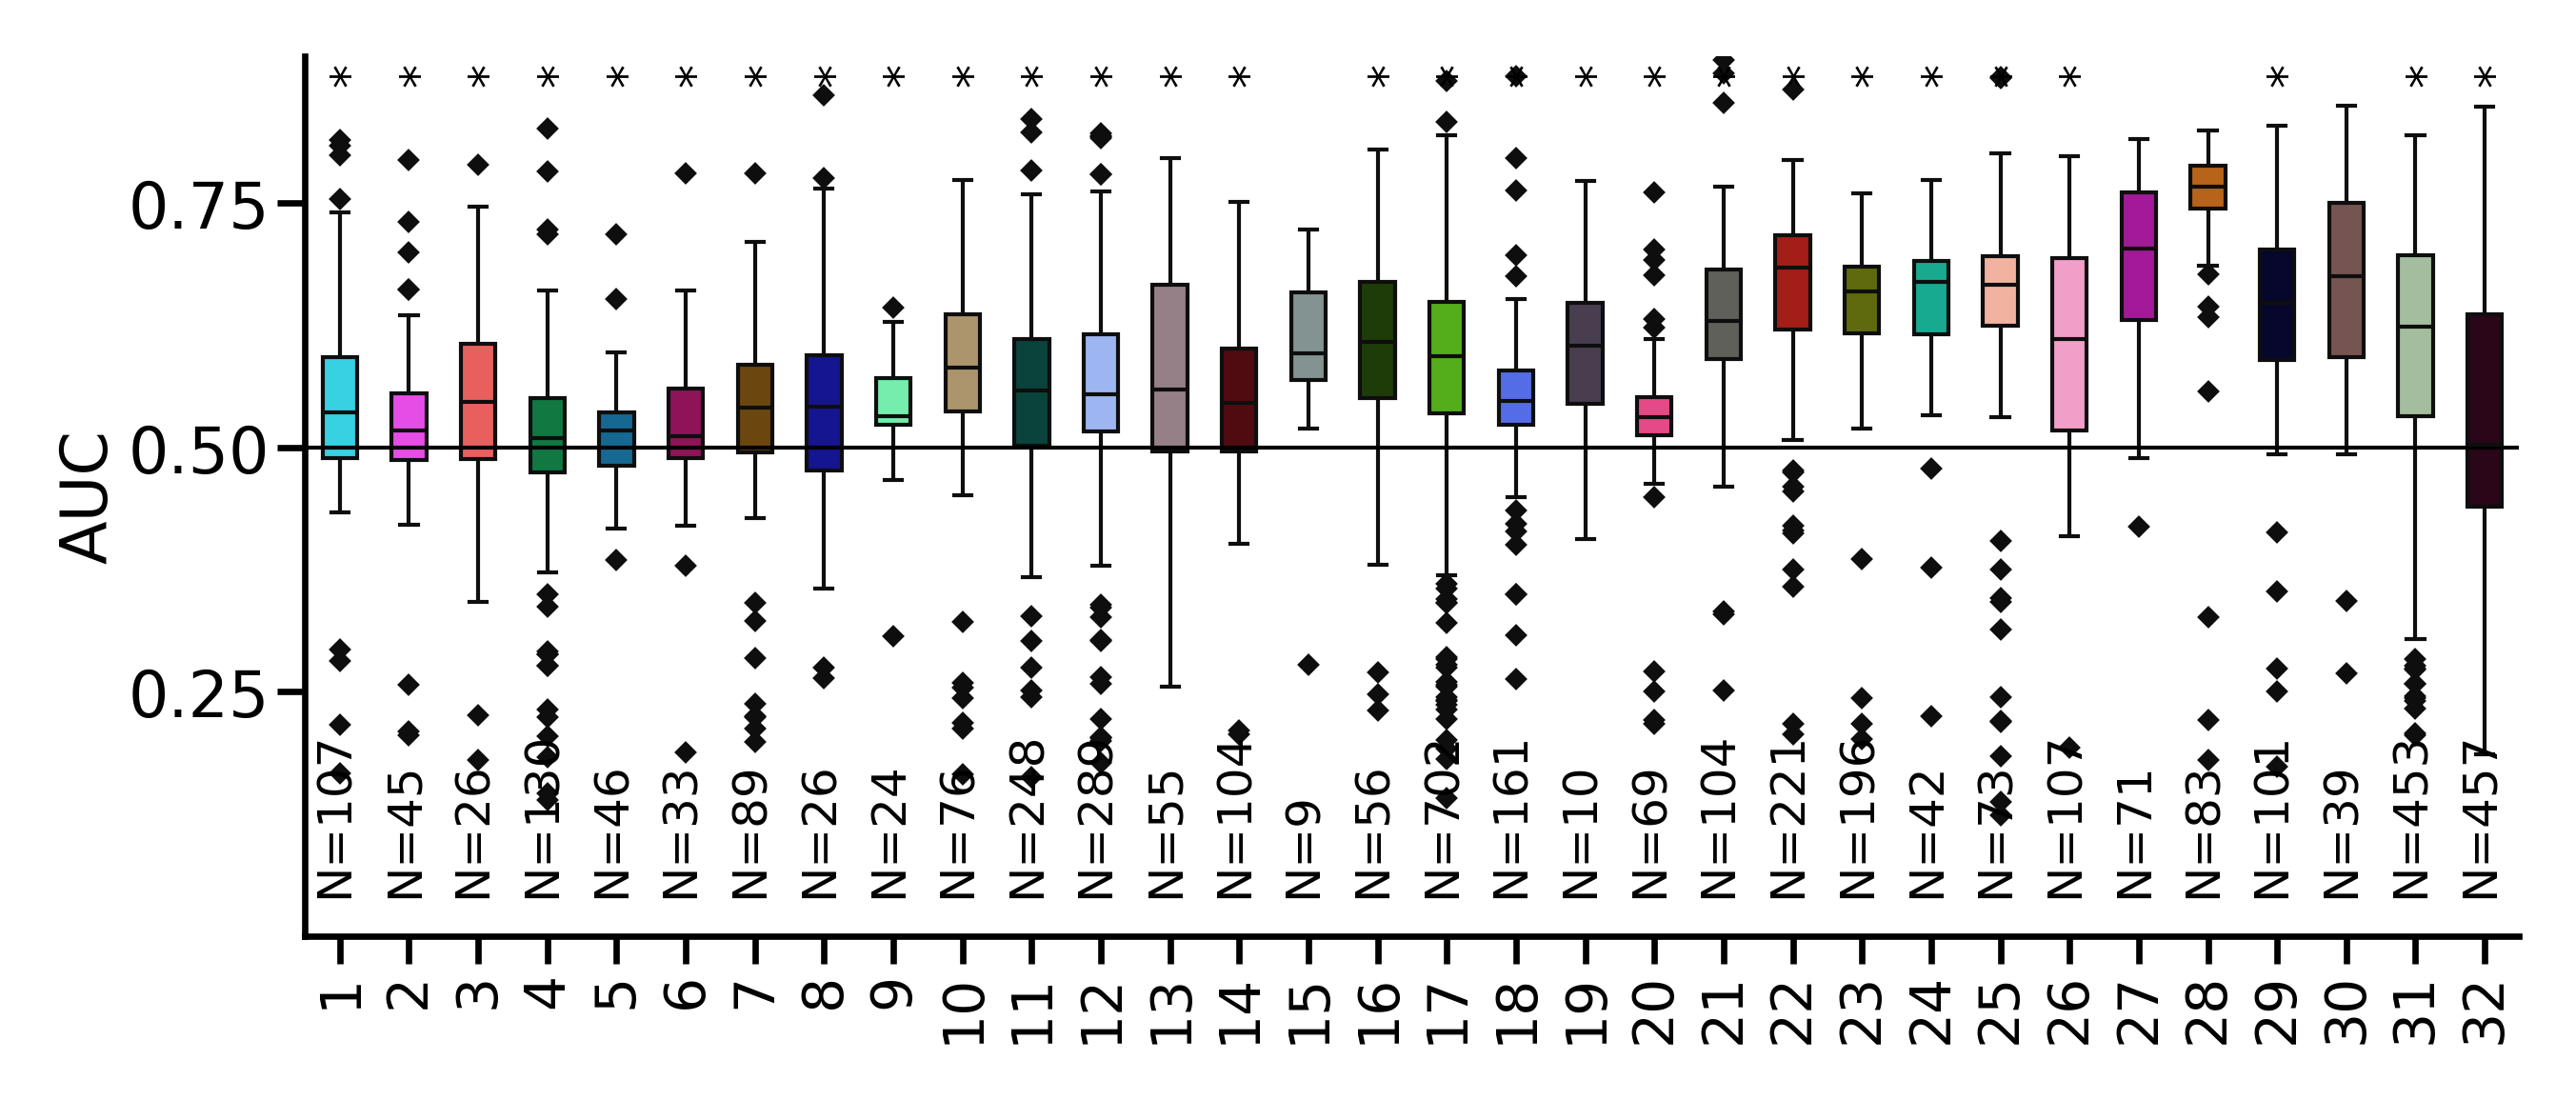

In [66]:
with mpl.rc_context(rc_dict_boxplot):
    sns.boxplot(data=[C_auc_by_type[t] for t in range(1, 33)], orient="v",
               palette=[rgc_colors[t-1] for t in range(1, 33)], fliersize=1, 
                width=.5,linewidth=0.5,flierprops={"marker": "D"},
                showmeans=False,meanprops={"marker": "o",
                       "markeredgecolor": "red",
                       "markersize": "2"});
    plt.gca().yaxis.set_major_locator(FixedLocator([0.25, 0.5, 0.75]))
    plt.gca().set_xticklabels(range(1, 33), rotation=90, fontsize=7)
    #plt.gca().set_xticklabels(["N = {:d}".format(len(auc_by_type[t])) for t in range(1, 33)], rotation=90)
    for t in range(1, 33):
        plt.annotate("N={}".format(len(C_auc_by_type[t])), xy=[t-1.4, 0.05], rotation="vertical", fontsize=6)
        if t not in asterik_types[speed]:
            print(t)
            plt.annotate("*",xy=[t-1.17,0.88],rotation='vertical',fontsize=6)
    sns.despine()
    plt.gca().axhline(0.5, color="k")
    # plt.gca().axhline(0.75, color="red",linestyle='dotted')
    # plt.gca().fill_between((26.5,27.5),1, color="red",alpha=0.2)
    # plt.xlabel("RGC group")
    plt.ylabel("AUC")
    plt.ylim(0, 0.9)